In [1]:
# Improve speed of SVC in sklearn might not be supported by some hardware if causes errors - ignore
# from sklearnex import patch_sklearn
# patch_sklearn("SVC")

If running in drive:

In [2]:
# # from google.colab import drive
# # drive.mount('/content/drive')

# from pathlib import Path
# import os

# # CHANGE ONLY THIS PATH AND EVERYTHING SHOULD RUN
# # Vlad's drive
# # notebooks_path = Path.cwd()/'drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det/notebooks'
# Joaquin's drive
# notebooks_path = Path.cwd()/'drive/MyDrive/calcification_detection/calc-det/notebooks'
# repo_path = notebooks_path.parent
# os.chdir(str(notebooks_path))

# thispath = Path.cwd().resolve()
# import sys; sys.path.insert(0, str(thispath.parent))

In [3]:
# inbreast_pngs_path = str(repo_path / 'data/INbreast\ Release\ 1.0/AllPNGs/full_imgs')
# inbreast_img_meta_path = str(repo_path / 'data/INbreast\ Release\ 1.0/images_metadata.csv')
# inbreast_rois_meta_path = str(repo_path / 'data/INbreast\ Release\ 1.0/rois_metadata.csv')
# inbreast_masks_path = str(repo_path / 'data/INbreast\ Release\ 1.0/AllMasks/full_imgs')

# det_checkpoints_path = str(repo_path / 'deep_learning/detection_models/checkpoints/')
# class_checkpoints_path = str(repo_path / 'deep_learning/classification_models/checkpoints/')

# !mkdir '/home/INbreast Release 1.0/'
# !mkdir '/home/INbreast Release 1.0/AllPNGs/'
# !mkdir '/home/INbreast Release 1.0/AllMasks/'

# !rsync -rva $inbreast_pngs_path '/home/INbreast Release 1.0/AllPNGs/'
# !rsync -rva $inbreast_img_meta_path '/home/INbreast Release 1.0/images_metadata.csv'
# !rsync -rva $inbreast_rois_meta_path '/home/INbreast Release 1.0/rois_metadata.csv'
# !rsync -rva $inbreast_masks_path '/home/INbreast Release 1.0/AllMasks/'

# !rsync -rva $det_checkpoints_path '/home/detection_checkpoints'
# !mv /home/detection_checkpoints/checkpoints/* '/home/detection_checkpoints/'
# !rmdir '/home/detection_checkpoints/checkpoints/'
# !rsync -rva $class_checkpoints_path '/home/classification_checkpoints'
# !mv /home/classification_checkpoints/checkpoints/* '/home/classification_checkpoints/'
# !rmdir '/home/classification_checkpoints/checkpoints/'

# !pip install -r ../requirements.txt

If running locally

In [1]:
from pathlib import Path
import os
notebooks_path = Path.cwd()
repo_path = notebooks_path.parent
os.chdir(str(notebooks_path))
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

Generate the dataset, for accessing the images and metadata

In [2]:
from database.dataset import INBreast_Dataset

db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions=['test'],
    lesion_types=['calcification', 'cluster'],
    cropped_imgs=True,
    keep_just_images_of_lesion_type=False,
    use_muscle_mask=False,
    ignore_diameter_px=15
)

Generate a function to run the model and store results over all samples in the dataset

In [3]:
import pickle
import time
import pandas as pd
import numpy as np
from tqdm import tqdm

from metrics.metrics_utils import get_froc_df_of_img, get_tp_fp_fn_center_patch_criteria

def get_froc_dataframe_from_set(db, detector, results_path, store_time = False):
    # get normal images
    normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()

    # define paths to store intermediate results
    results_path = Path(results_path)
    if not results_path.exists():
        results_path.mkdir(parents=True, exist_ok=True)
    frocs_df_path = results_path / 'froc_df.csv'
    times_path = results_path / 'times.p'
    froc_dfs = []
    times = []

    # get the detections for each image in the database
    for idx in tqdm(range(len(db))):
        # get sample
        db_sample = db[idx]
        image = db_sample['img']
        image_id = db_sample['img_id']
        image_mask = db_sample['lesion_mask']

        start = time.time()
        detections = detector.detect(image)
        times.append(time.time()-start)

        # reformat detections
        detections_centers_and_radius = np.stack(detections['candidate_coordinates'].values).astype(int)
        detections_scores = detections['confidence'].values.reshape(-1, 1)
        # retain the centers and scores:
        candidates = np.concatenate([detections_centers_and_radius, detections_scores], axis = 1)

        # compare with labels
        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(
            candidates, image_mask, None, 14, use_euclidean_dist=True, scores_passed=True)
        candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

        # generate standard dataframe
        froc_df = get_froc_df_of_img(
            candidates, fn, candidates['score'], image_id, (image_id in normal_imgs_ids))
        
        froc_dfs.append(froc_df)
    
    # store full
    froc_dfs = pd.concat(froc_dfs, ignore_index=True)
    froc_dfs.to_csv(frocs_df_path)
    if store_time:
        with open(times_path, 'wb') as f:
            pickle.dump(times, f)
    return froc_dfs

In [4]:
from machine_learning.ml_detector import DetectorML
from general_utils.plots import plot_froc, plot_several_frocs, add_detections_overlay
from metrics.metrics import froc_curve
from metrics.metrics_utils import best_th_froc_curve
import general_utils.utils as utils
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None 

Instatiate the detector

In [5]:
model_chkpt_path = str('/home/vzalevskyi/projects/data/cascade/cascade_models.pkl')
detector = DetectorML(model_chkpt_path)

INFO:root:Loading model...
INFO:root:Selected keep_sens_thr=0.98
Max_conf_thr_required to keep given sensitivity is 0.00350



run on the complete validation dataset

In [6]:
results_path = repo_path.parent / 'detections_dl/aia_ml_cascaded_svc'
froc_dfs = get_froc_dataframe_from_set(db, detector, results_path, store_time = True)

100%|██████████| 200/200 [2:26:43<00:00, 44.02s/it]  


Distribution of labels across predictions

In [7]:
froc_dfs.label.value_counts()

FP    186282
TP      1960
FN       357
Name: label, dtype: int64

FROC curve

Threshold: 0.15705119260699243, TPR: 0.6928838951310862, FPR: 4.19


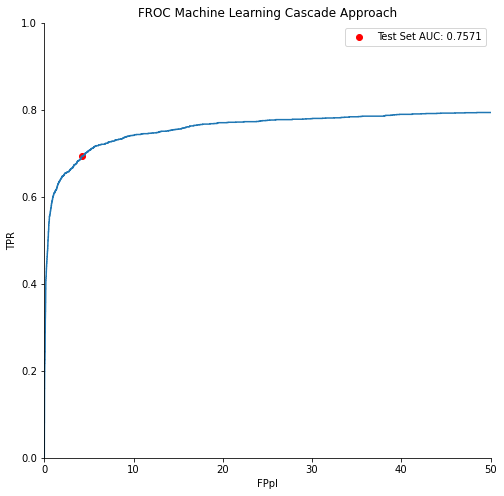

In [11]:
sens, avgs_fp_per_image, thresholds = froc_curve(froc_dfs, non_max_supression=True, cut_on_50fpi=True)
th, tpr, fpr = best_th_froc_curve(np.asarray(sens), np.asarray(avgs_fp_per_image), np.asarray(thresholds))
print(f'Threshold: {th}, TPR: {tpr}, FPR: {fpr}')
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(fpr, tpr, label='selected point', c='r')
plot_froc(avgs_fp_per_image, sens, label='Test Set', title='FROC Machine Learning Cascade Approach', ax=ax)

Visualization of detections

INFO:root:Loading model...
INFO:root:Selected keep_sens_thr=1.0
Max_conf_thr_required to keep given sensitivity is 0.00035



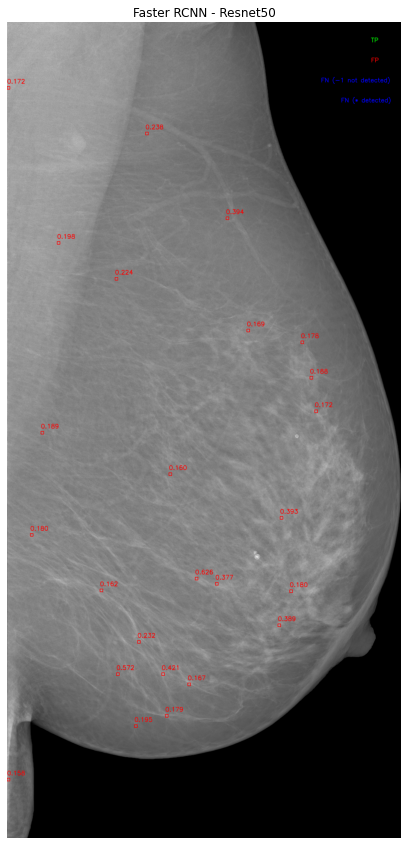

In [9]:
# instatiate the model
model_chkpt_path = str(repo_path / 'machine_learning/checkpoints/cascade_models.pkl')
detector = DetectorML(model_chkpt_path)

# get image
idx = 22
db_sample = db[idx]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

# get detections
detections = detector.detect(image)

# reformat detections
detections_centers_and_radius = np.stack(detections['candidate_coordinates'].values).astype(int)
detections_scores = detections['confidence'].values.reshape(-1, 1)
# retain the centers and scores:
detections = np.concatenate([detections_centers_and_radius, detections_scores], axis = 1)

# Generate the images
image = add_detections_overlay(
    image, detections, image_mask, conf_thr=0.13444709378395178, k=0, need_labeling = True)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
ax.set_title('Faster RCNN - Resnet50')
ax.imshow(image)
ax.axis('off')
plt.show()

Store to dcm example

In [10]:
# instatiate the model
model_chkpt_path = str(repo_path / 'machine_learning/checkpoints/cascade_models.pkl')
detector = DetectorML(model_chkpt_path)

# get image
idx = 22
db_sample = db[idx]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

# get detections
detections = detector.detect(image)

# reformat detections
detections_centers_and_radius = np.stack(detections['candidate_coordinates'].values).astype(int)
detections_scores = detections['confidence'].values.reshape(-1, 1)
# retain the centers and scores:
detections = np.concatenate([detections_centers_and_radius, detections_scores], axis = 1)

fields = ['img_id', 'case_id', 'side', 'view', 'breast_bbox']
fields = db.img_df.loc[db.img_df.img_id == image_id, fields].values[0]
view = 'ML' if fields[3] == 'MLO' else fields[3]
dcm_img_name = f'{fields[0]}_{fields[1]}_MG_{fields[2]}_{view}_ANON.dcm'
dcm_path = repo_path / 'data/INbreast\ Release\ 1.0/AllDICOMs/'
original_dcm_filepath = dcm_path/dcm_img_name
breast_bbox = fields[-1]

output_filepath = repo_path.parent / 'ml_det_example.dcm'

detections_df = pd.DataFrame(detections, columns=['x', 'y', 'radius', 'score'])
detections_df = detections_df.loc[detections_df.score >= 0.13444709378395178, :]

!cp $original_dcm_filepath $repo_path.parent
!rm $output_filepath
original_dcm_filepath = repo_path.parent/dcm_img_name

utils.store_as_dcm(
    image, detections_df, original_dcm_filepath, output_filepath, breast_bbox)

INFO:root:Loading model...
INFO:root:Selected keep_sens_thr=1.0
Max_conf_thr_required to keep given sensitivity is 0.00035



rm: cannot remove '/home/vzalevskyi/projects/ml_det_example.dcm': No such file or directory
